In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# define key directories
scratch = '/scratch/08811/aew492/small-scale_cross-corrs'
work = '/work/08811/aew492/ls6/small-scale_cross-corrs'

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.integrate import trapz
import illustris_python as il
# from Corrfunc.theory.xi import xi
# from Corrfunc.theory.wp import wp
import os
import sys
sys.path.insert(0, work)
from corrfunc_ls import compute_3D_ls, compute_2D_ls
from tools import get_subsample

### load Illustris data

Snapshot 67 corresponds to redshift $z\sim 0.5$.

Get a 3D box with only dark matter particles:

In [4]:
# define output directory
basepath = os.path.join(scratch, 'Illustris-3/output')
# load in dark matter particle coordinates
dm_pos = il.snapshot.loadSubset(basepath, 67, 'dm', ['Coordinates'])
# convert from kpc -> Mpc
dm_pos /= 1000

In [5]:
# how many particles?
len(dm_pos)

94196375

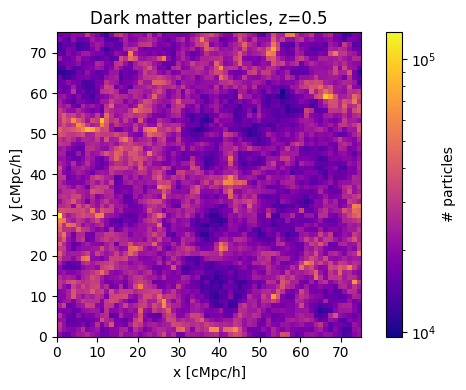

In [6]:
fig, ax = plt.subplots(figsize=(5.5,4))
_, _, _, im = ax.hist2d(dm_pos[:,0], dm_pos[:,1], cmap='plasma', norm=mpl.colors.LogNorm(), bins=64)
ax.set_xlim([0,75])
ax.set_ylim([0,75])
ticks = np.linspace(0, 70, 8)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_aspect('equal')
ax.set_xlabel('x [cMpc/h]')
ax.set_ylabel('y [cMpc/h]')
fig.colorbar(im, ax=ax, label='# particles')
ax.set_title('Dark matter particles, z=0.5')
fig.tight_layout()

### Compute 3D 2pt autocorrelation

In [7]:
# subsample 1/100th
dm_subsample = get_subsample(dm_pos, nx=100)

subsampling 941963 random particles...


In [8]:
# parameters for Corrfunc
randmult = 3
rmin = 0.1
rmax = 20.
nbins = 20

In [9]:
%%time
ravg, xi = compute_3D_ls(dm_subsample, randmult, rmin, rmax, nbins, nthreads=24)

CPU times: user 14min 56s, sys: 335 ms, total: 14min 57s
Wall time: 38.1 s


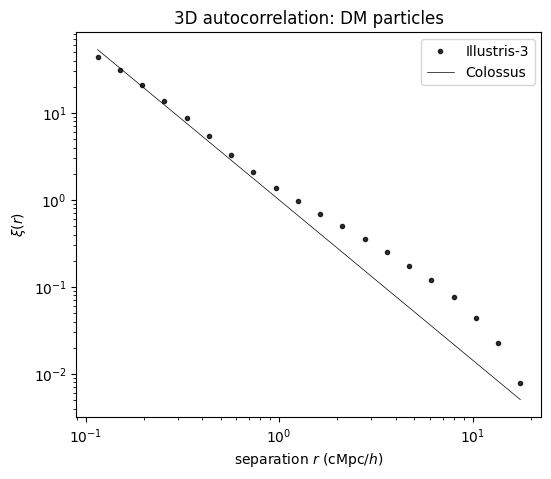

In [10]:
fig, ax = plt.subplots(figsize=(6,5))

ax.plot(ravg, xi, color='k', marker='.', ls='None', alpha=0.8, label='Illustris-3')
ax.plot(ravg, (ravg)**(-1.84), lw=0.5, color='k', label='Colossus')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'separation $r$ (cMpc/$h$)')
ax.set_ylabel(r'$\xi (r)$')
ax.set_title(r'3D autocorrelation: DM particles')
ax.legend()

### Compute projected (2D) 2pt autocorrelation

A bit about $w_p(r_p)$:

$r_p$ = projected separation between pairs

$\pi$ = line-of-sight separation between pairs;
only pairs with $\pi$ separation less than $\pi_\mathrm{max}$ are counted

In [11]:
pimax = 20.0  # distance to integrate along line of sight

In [14]:
rpmin = 0.08
rpmax = 15.
nbins = nbins

In [15]:
%%time
rpavg, wp = compute_2D_ls(dm_subsample, randmult, rpmin, rpmax, nbins, pimax, nthreads=24)

CPU times: user 23min 13s, sys: 331 ms, total: 23min 14s
Wall time: 58.5 s


Text(0.5, 1.0, '2D projected autocorrelation: DM particles')

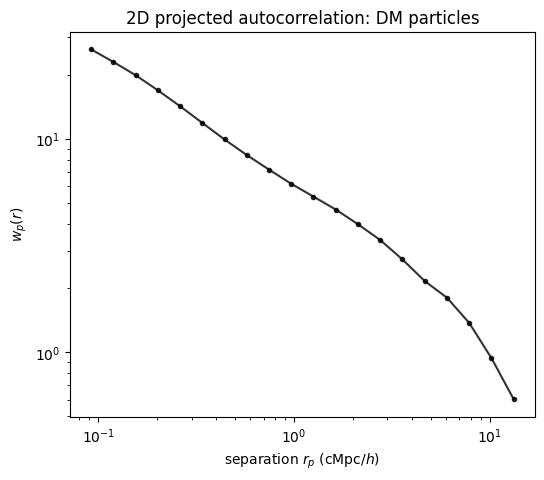

In [16]:
fig, ax = plt.subplots(figsize=(6,5))

ax.plot(rpavg, wp, color='k', marker='.', ls='-', alpha=0.8)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'separation $r_p$ (cMpc/$h$)')
ax.set_ylabel(r'$w_p (r)$')
ax.set_title(r'2D projected autocorrelation: DM particles')

#### check that $w_p$ is the integral of $\xi$

$$
w_p(r_p)=2\int_{rp}^\infty \xi(r)(r^2-r_p^2)^{-1/2}\,dr
$$

In [17]:
def xi_int(rp, xi, r):
    integrand = xi*(r**2 - rp**2)**(-1/2)
    return 2 * trapz(integrand, x=r)

In [22]:
xiint = np.array([xi_int(rp, xi, ravg) for rp in rpavg])

/tmp/ipykernel_1806611/339028251.py:2: RuntimeWarning: invalid value encountered in power
  integrand = xi*(r**2 - rp**2)**(-1/2)


In [26]:
xiint

array([77.0311518,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan])